# DataLake Class

The `DataLake` class is a holder and merger of multiple `DataStreams`. This will be the main class that you will be using to load data and perform operations on it.


```python
class DataLake():
    """
    DataLake class to store and manage datastreams.

    This class provides a simple way to manage multiple datastreams, where
    each datastream is stored as a separate instance of the DataStream class.
    Datastreams can be added to the DataLake using the add_data method, and
    can be accessed or modified using the various methods provided by the
    DataStream class.

    Attributes:
    ----------
        settings (dict): A dictionary of settings for each datastream to be
            added to the DataLake. The keys of the dictionary should be the
            names of the datastreams, and the values should be dictionaries
            containing the settings for each datastream.
        path (str): The path to the data to be read in. Default is None.
        utc_to_local (int): The UTC to local time offset in hours.
            Default is 0.

    Methods:
    ----------
        list_datastreams: Returns a list of the datastreams in the DataLake.
        update_datastream: Updates all datastreams in the DataLake.
        add_processed_datastream: Adds a processed datastream to the DataLake.
        initialise_datastream: Initialises a datastream using the settings in
            the DataLake object.
        reaverage_datastream: Reaverages the data in the specified datastream.
        remove_zeros: Removes filter/zeros from the specified datastream.
```


## Imports

Load the required modules.

In [1]:
import numpy as np
from matplotlib import pyplot as plt, dates
import os
from datetime import datetime

from datacula.lake.datalake import DataLake


# preferred settings for plotting
plt.rcParams.update({'text.color': "#333333",
                     'axes.labelcolor': "#333333",
                     "figure.figsize": (6,4),
                     "font.size": 14,
                     "axes.edgecolor": "#333333",
                     "axes.labelcolor": "#333333",
                     "xtick.color": "#333333",
                     "ytick.color": "#333333",
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})

## DataLake Settings

The initial settings dictionary holds all dataformat information, so it can get a little complex. We show and example here for the APS_data, CAPS_dual_data, CPC_3010_data, PASS3_data and SMPS_data files. This should give you an idea of how to set up the settings dictionary for your own data.

You settings could be saved as a JSON file and loaded in, but we will just set them up manually here.

The general format is:

```python

"instrument_name": str  # the name of the instrument that generated the data (in this case, "PASS3").
"data_stream_name": str  # a short name for the data stream.
"data_processing_function": str  # the name of a Python function that should be used to process the data (not specified in this case).
"data_loading_function": str  # the name of a Python function that should be used to load the data.
"relative_data_folder": str  # the name of the folder where the data is stored relative to the project directory.
"skipRowsDict": int  # the number of rows to skip when loading the data (not specified in this case).
"Time_shift_to_Linux_Epoch_sec": int  # the time shift in seconds to convert to Linux Epoch time (not specified in this case).
"data_checks": dic[str]  # a dictionary that specifies various checks to perform on the data, such as the expected number of characters and delimiters.
"data_header": list[str]  # a list of column headers for the data.
"data_column": list[int]  # a list of column indices for the data.
"time_column": list[int]  # a list of column indices that specify the time data.
"time_format": str  # the format of the time data.
"filename_regex": str  #a regular expression that matches the filenames of the data files.
"base_interval_sec": int  # the time interval in seconds for the data.
"data_delimiter": str  # the delimiter used in the data file.

```

There is a difference for 2d data, like APS and SMPS, where the data is stored in a 2d array. In this case, the data_header and data_column are lists of lists, where each list contains the headers and column indices for each 2d array. It produces two data streams, one for the 1d data and one for the 2d data.

```python

"instrument_name": str  # the name of the instrument that generated the data (in this case, "SMPS_data").
"data_stream_name": str  # a list of two names for the data streams.
"data_processing_function": str  # the name of a Python function that should be used to process the data ("SMPS_processing").
"data_loading_function": str  #the name of a Python function that should be used to load the data ("general_2d_sizer_load").
"relative_data_folder": str  #the name of the folder where the data is stored relative to the project directory.
"skipRowsDict": int  #the number of rows to skip when loading the data (not specified in this case).
"Time_shift_to_Linux_Epoch_sec": int  # the time shift in seconds to convert to Linux Epoch time (not specified in this case).
"data_checks": dic[str]  #a dictionary that specifies various checks to perform on the data, such as the expected number of characters and delimiters.
"data_sizer_reader": list[str]  # a dictionary that specifies how to read the sizer data, including the number of header rows, the starting and ending keywords for the diameter data, and a list of column headers.
"data_header": list[str]  # a list of column headers for the data.
"time_column": list[str]  #a list of column indices that specify the time data.
"time_format": str  # the format of the time data.
"filename_regex": str  # a regular expression that matches the filenames of the data files.
"base_interval_sec": int  # the time interval in seconds for the data.
"data_delimiter": str  # the delimiter used in the data file.

```

In [2]:
lake_settings = {
    "PASS3_data": {
        "instrument_name": "PASS3",
        "data_stream_name": "pass3",
        "data_processing_function": "",
        "data_loading_function": "general_load",
        "relative_data_folder": "PASS3_data",
        "skipRowsDict": 0,
        "Time_shift_to_Linux_Epoch_sec": 0,
        "data_checks": {
            "characters": [0,1100],
            "char_counts": {",": 63, ":": 2},
            "skip_rows": 1,
            "skip_end": 0
        },
        "data_header": [
            "Babs405nm[1/Mm]",
            "Babs532nm[1/Mm]",
            "Babs781nm[1/Mm]",
            "Pressure[mb]",
            "Temperature[C]",
            "RH[%]",
            "Bsca405nm[1/Mm]",
            "Bsca532nm[1/Mm]",
            "Bsca781nm[1/Mm]",
            "BabsBGR405nm[1/Mm]",
            "BabsBGR532nm[1/Mm]",
            "BabsBGR781nm[1/Mm]",
            "BscaBGR405nm[1/Mm]",
            "BscaBGR532nm[1/Mm]",
            "BscaBGR781nm[1/Mm]",
            "Zero"
        ],
        "data_column": [
            5,
            6,
            7,
            29,
            30,
            31,
            33,
            34,
            35,
            37,
            38,
            39,
            57,
            58,
            59,
            56
        ],
        "time_column": [0,1],
        "time_format": "%Y%m%d %H:%M:%S",
        "filename_regex": "*BabsBGR_*.txt",
        "base_interval_sec": 2,
        "data_delimiter": ","
    },
    "CPC_3010_data": {
        "instrument_name": "CPC_3010",
        "data_stream_name": "cpc_3010",
        "data_processing_function": "",
        "data_loading_function": "general_load",
        "relative_data_folder": "CPC_3010_data",
        "skipRowsDict": 0,
        "Time_shift_to_Linux_Epoch_sec": 0,
        "data_checks": {
            "characters": [20,35],
            "char_counts": {",": 4, "/": 0, ":": 0},
            "skip_rows": 1,
            "skip_end": 0
        },
        "data_header": ["CPC_count[#/sec]", "Temp_[C]"],
        "data_column": [1,2],
        "time_column": 0,
        "time_format": "epoch",
        "filename_regex": "CPC_3010*.csv",
        "base_interval_sec": 2,
        "data_delimiter": ","
    },
    "CAPS_dual_data": {
        "instrument_name": "CAPS_dual",
        "data_stream_name": "caps_dual",
        "data_processing_function": "CAPS_turncation",
        "data_loading_function": "general_load",
        "relative_data_folder": "CAPS_dual_data",
        "skipRowsDict": 0,
        "Time_shift_to_Linux_Epoch_sec": 0,
        "data_checks": {
            "characters": [200],
            "skip_rows": 1,
            "skip_end": 0,
            "char_counts": {",": 42, "/": 2, ":": 2},
        },
        "data_header": [
            "Bext_wet_CAPS_450nm[1/Mm]",
            "Bsca_wet_CAPS_450nm[1/Mm]",
            "Temp_wet_CAPS[K]",
            "Bext_dry_CAPS_450nm[1/Mm]",
            "Bsca_dry_CAPS_450nm[1/Mm]",
            "Temp_dry_CAPS[K]",
            "Wet_RH_preCAPS[%]",
            "Wet_RH_postCAPS[%]",
            "Humidifier_RH_CAPS[%]",
            "dualCAPS_inlet_RH[%]",
            "Wet_Temp_preCAPS[C]",
            "Wet_Temp_postCAPS[C]",
            "Humidifier_Temp[C]",
            "dualCAPS_inlet_Temp[C]",
            "Zero_dry_CAPS",
            "Zero_wet_CAPS"
        ],
        "data_column": [
            2,
            3,
            6,
            17,
            18,
            21,
            32,
            33,
            34,
            35,
            36,
            37,
            38,
            39,
            41,
            42
        ],
        "time_column": 0,
        "time_format": "%m/%d/%Y %I:%M:%S %p",
        "filename_regex": "*.CAPS",
        "base_interval_sec": 2,
        "data_delimiter": ","
    },
    "SMPS_data": {
        "instrument_name": "SMPS_data",
        "data_stream_name": ["smps_1D", "smps_2D"],
        "data_processing_function": "SMPS_processing",
        "data_loading_function": "general_2d_sizer_load",
        "relative_data_folder": "SMPS_data",
        "skipRowsDict": 0,
        "Time_shift_to_Linux_Epoch_sec": 0,
        "data_checks": {
            "characters": [200],
            "skip_rows": 24,
            "skip_end": 0,
            "char_counts": {"/": 2, ":": 2},
        },
        "data_sizer_reader": {
            "header_rows": 24,
            "Dp_start_keyword": "Diameter Midpoint (nm)", 
            "Dp_end_keyword": "Scan Time (s)",
            "list_of_data_headers": [
                "Lower Size (nm)", 
                "Upper Size (nm)",
                "Sample Temp (C)",
                "Sample Pressure (kPa)",
                "Relative Humidity (%)",
                "Median (nm)",
                "Mean (nm)",
                "Geo. Mean (nm)",
                "Mode (nm)",
                "Geo. Std. Dev.",
                "Total Conc. (#/cm³)"]
            },
        "data_header": [
            "Lower_Size_(nm)",
            "Upper_Size_(nm)",
            "Sample_Temp_(C)",
            "Sample_Pressure_(kPa)",
            "Relative_Humidity_(%)",
            "Median_(nm)",
            "Mean_(nm)",
            "Geo_Mean_(nm)",
            "Mode_(nm)",
            "Geo_Std_Dev.",
            "Total_Conc_(#/cc)"
        ],
        "time_column": [1,2], 
        "time_format": "%m/%d/%Y %H:%M:%S",
        "filename_regex": "*.csv",
        "base_interval_sec": 90,
        "data_delimiter": ","
    },
    "APS_data": {
        "instrument_name": "APS",
        "data_stream_name": ["aps_1D", "aps_2D"],
        "data_processing_function": "APS_processing",
        "data_loading_function": "general_2d_sizer_load",
        "relative_data_folder": "APS_data",
        "skipRowsDict": 0,
        "Time_shift_to_Linux_Epoch_sec": 0,
        "data_checks": {
            "characters": [200],
            "skip_rows": 6,
            "skip_end": 0,
            "char_counts": {"/": 4, ":": 2},
        },
        "data_sizer_reader": {
            "header_rows": 6,
            "Dp_start_keyword": "<0.523", 
            "Dp_end_keyword": "Event 1",
            "list_of_data_headers": [
                "<0.523", 
                "Total Flow",
                "Box Temperature",
                "Median(�m)",
                "Mean(�m)",
                "Geo. Mean(�m)",
                "Mode(�m)",
                "Geo. Std. Dev."]
            },
        "data_header": [
            "Lower_Size_(um)",
            "Total_flow",
            "Box_Temperature[C]",
            "Median_(um)",
            "Mean_(um)",
            "Geo_Mean_(um)",
            "Mode_(um)",
            "Geo_Std_Dev"],
        "time_column": [1,2],
        "time_format": "%m/%d/%y %H:%M:%S",
        "filename_regex": "*.txt",
        "base_interval_sec": 60,
        "data_delimiter": ","
    }
}

## Initialise DataLake

Initialise the DataLake object. We need to provide, a settings dictionary, and the path to the data.

```python
"""
    Initializes the DataLake object.

    Parameters:
    ----------
        settings (dict): A dictionary of settings for each datastream to
            be added to the DataLake. The keys of the dictionary should be
            the names of the datastreams, and the values should be
            dictionaries containing the settings for each datastream.
        path (str, optional): The path to the data to be read in.
            Default is None.
        utc_to_local (int, optional): The UTC to local time offset
            in hours. Default is 0. TODO: add UTC time zone support
"""
```

In [3]:
path = os.getcwd()

data_path = os.path.join(path, 'data')

print(data_path)

c:\Users\kkgor\OneDrive\Areas\GitHub\datacula\docs\examples\data


In [4]:
# Initialize the data lake
my_lake = DataLake(settings=lake_settings, path=data_path)

## Add the Data

Now that we are initialized, we can trigger the loading of the data. This will load the data into the DataLake object, and create a new DataStream object for each datastream in the settings dictionary.



In [5]:
my_lake.update_datastream()

Initialising datastream:  PASS3_data
Loading data from: BabsBGR_20220709.txt
Loading data from: BabsBGR_20220710.txt
Initialising datastream:  CPC_3010_data
Loading data from: CPC_3010_data_20220701_Jul.csv


C:\Users\kkgor\OneDrive\Areas\GitHub\datacula\datacula\loader.py:148: UserWarning: More than 0.5 of the rows have been filtered out based on the characters limit [20, 35] or skip rows.
  warnings.warn(


Loading data from: CPC_3010_data_20220709_Jul.csv
Loading data from: CPC_3010_data_20220710_Jul.csv
Initialising datastream:  CAPS_dual_data
Loading data from: 07092022.CAPS
Loading data from: 07102022.CAPS
Initialising datastream:  SMPS_data
Loading data from: 2022-07-07_095151_SMPS.csv
Loading data from: 2022-07-10_094659_SMPS.csv
Initialising datastream:  APS_data
Loading data from: TRACER-CAT-20220707.txt
Loading data from: TRACER-CAT-20220710.txt


## Now we can plot

With the data loaded we can average it and plot it. 

In [6]:
my_lake.reaverage_datastreams(average_base_sec=600)
my_lake.list_datastreams()

['pass3', 'cpc_3010', 'caps_dual', 'smps_1D', 'smps_2D', 'aps_1D', 'aps_2D']

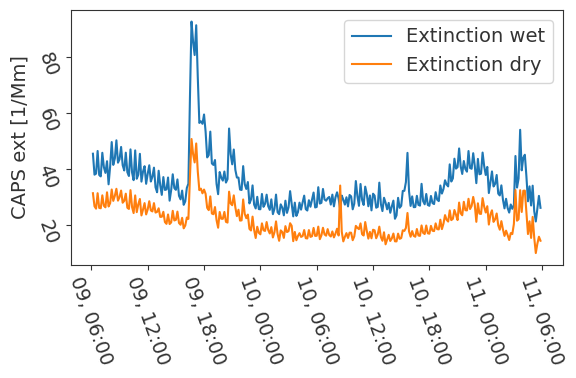

In [7]:
fig, ax = plt.subplots()
ax.plot(
    my_lake.datastreams['caps_dual'].return_time(datetime64=True),
    my_lake.datastreams['caps_dual'].return_data(keys=['Bext_wet_CAPS_450nm[1/Mm]'])[0],
    label='Extinction wet'
)
ax.plot(
    my_lake.datastreams['caps_dual'].return_time(datetime64=True),
    my_lake.datastreams['caps_dual'].return_data(keys=['Bext_dry_CAPS_450nm[1/Mm]'])[0],
    label='Extinction dry'
)

plt.tick_params(rotation=-70)
ax.set_ylabel('CAPS ext [1/Mm]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d, %H:%M'))
ax.legend()
fig.tight_layout()

## Sizer Data timeseries

If you forgot the header options in the data stream, you can always get the list.

In [8]:
print('1D time series headers')
my_lake.datastreams['smps_1D'].return_header_dict()


1D time series headers


{'Lower_Size_(nm)': 0,
 'Upper_Size_(nm)': 1,
 'Sample_Temp_(C)': 2,
 'Sample_Pressure_(kPa)': 3,
 'Relative_Humidity_(%)': 4,
 'Median_(nm)': 5,
 'Mean_(nm)': 6,
 'Geo_Mean_(nm)': 7,
 'Mode_(nm)': 8,
 'Geo_Std_Dev.': 9,
 'Total_Conc_(#/cc)': 10}

## Plot 1d sizer data

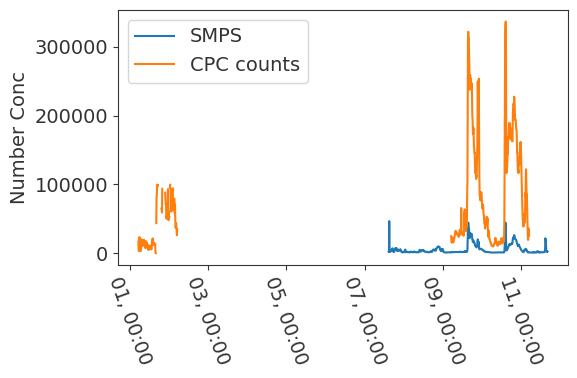

In [9]:
fig, ax = plt.subplots()
ax.plot(
    my_lake.datastreams['smps_1D'].return_time(datetime64=True),
    my_lake.datastreams['smps_1D'].return_data(keys=['Total_Conc_(#/cc)'])[0],
    label='SMPS'
)
ax.plot(
    my_lake.datastreams['cpc_3010'].return_time(datetime64=True),
    my_lake.datastreams['cpc_3010'].return_data(keys=['CPC_count[#/sec]'])[0],
    label='CPC counts'
)
plt.tick_params(rotation=-70, axis='x')
ax.set_ylabel('Number Conc')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d, %H:%M'))
ax.legend()
fig.tight_layout()

## Plot 2d sizer data

We can pull the whole 2d sizer data and plot it as well.

In [ ]:
dp = my_lake.datastreams['smps_2D'].return_header_list()
dp = np.array(dp, dtype=float)

concentration = my_lake.datastreams['smps_2D'].return_data()

print(f"dp shape: {dp.shape} and concentration shape: {concentration.shape}")

From the shapes you can see the first dimension is the dp, and the second dimension is the time. We can plot this as a 2d image using contourf.

We will first scale the concentration to a log scale, and crop the data heights to see the data better.

In [ ]:
concentration_log10 = np.clip(np.log10(concentration), a_min=0, a_max=5)  # clip to resolve banna curves.

fig, ax = plt.subplots(1,1)
plt.contourf(
    my_lake.datastreams['smps_2D'].return_time(datetime64=True),
    dp,
    concentration_log10,
    cmap=plt.cm.PuBu, levels=50)
ax.set_yscale('log')
ax.set_ylabel('Dp (nm)')
plt.tick_params(rotation=-70, axis='x')
plt.colorbar(label='Concentration [log10 #/cm3]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d, %H:%M'))
fig.tight_layout()


## Plot APS data

We can make a similar plot for the APS data.

In [ ]:
dp_aps = my_lake.datastreams['aps_2D'].return_header_list()
dp_aps = np.array(dp_aps, dtype=float)
concentration_aps = my_lake.datastreams['aps_2D'].return_data()

concentration_aps_log10 = np.clip(np.log10(concentration_aps), a_min=0, a_max=4)  # clip to resolve banna curves.

fig, ax = plt.subplots(1,1)
plt.contourf(
    my_lake.datastreams['aps_2D'].return_time(datetime64=True),
    dp_aps,
    concentration_aps_log10,
    cmap=plt.cm.PuBu, levels=50)
ax.set_yscale('log')
ax.set_ylabel('Dp (microns)')
plt.tick_params(rotation=-70, axis='x')
plt.colorbar(label='Concentration [log10 #/cm3]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d, %H:%M'))
fig.tight_layout()